# Invader Defender 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pickle
from scipy.optimize import linprog

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) 
gridSize = 6 
state_count = gridSize*gridSize

In [3]:
class Invader_Defender():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        
        # deterministic transition ?
        self.transition_prob = 1 
        
        # initialize defender and invader states
        self.new_state = [0, 0, 0, 0]
        self.new_defender_state = [0, 0]
        self.new_invader_state = [0, 0]
        
        # set territory state
        self.territory_state = [4, 4]

        # create a list of all possible states in the game
        self.game_state_list = []
        for defender_state in self.states:
            for invader_state in self.states:
                combined_states = defender_state + invader_state
                self.game_state_list.append(combined_states)
        
        # create 2 lists of states representing defender and invader victory
        self.defender_won = []
        self.invader_won = []
        
        # create states representing defender victory
        for defender_state in self.states:
            for invader_state in self.states:
                distance = np.linalg.norm(np.array(defender_state) - np.array(invader_state))
                # if the invader is not at territory and within the capture range of defender = defender won
                if invader_state != self.territory_state and distance <= np.sqrt(2):
                    combined_states = defender_state + invader_state
                    self.defender_won.append(combined_states)
           
        # create states representing invader victory
        for defender_state in self.states:
            distance = np.linalg.norm(np.array(defender_state) - np.array(self.territory_state))
            # if the invader is at territory, and outside of the defender's capture range = invader won
            if distance > np.sqrt(2):
                combined_states = defender_state + self.territory_state
                self.invader_won.append(combined_states)
    
    def possible_states(self):
        """
        A function that returns a list of all possible states in the game
        """
        return self.game_state_list
    
    def terminal_check(self, state):
        """
        A function that checks whether the game is at a terminal state.
        Terminal state happens when either the invader or defender has won.
        """
        if state in self.defender_won:
            status = "Defender Won"
            terminal_check = True
        elif state in self.invader_won:
            status = "Invader Won"
            terminal_check = True
        else:
            terminal_check = False
            status = "Game in Progress"

        return terminal_check, status
    
#     def transition_probability(self, transition):
#         """
#         A function that returns the transition probability...?
#         """
#         return self.transition_prob, reward

    def next_state(self, current_state, defender_action, invader_action):
        """
        A function that returns the next state
        Input: current state [0,0] , defender_action [0, 1], invader_action [0,-1]
        Output: next state array([x1,y1,x2,y2]) and reward (int)
            - If the action takes the agent off grid, the agent remains in original state
            - If defender won, reward is calculated based on manhattan distance between invader captured state
            and territory
            - If defender loss, reward is -100
        """
        defender_state = []
        invader_state = []
        
        # deconstruct current state [0,0,1,1] in to defender [0,0] and invader [1,1] state
        for i in range(4):
            if i < 2:
                defender_state.append(current_state[i])
            else:
                invader_state.append(current_state[i])
                
        # get next state: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_defender_state = list(np.array(defender_state) + np.array(defender_action))
        self.new_invader_state = list(np.array(invader_state) + np.array(invader_action))

        # if new defender states results in off the grid, return to original state
        if -1 in self.new_defender_state or self.size in self.new_defender_state:
            self.new_defender_state = defender_state
        
        # if new invader states results in off the grid, return to original state
        if -1 in self.new_invader_state or self.size in self.new_invader_state:
            self.new_invader_state = invader_state
       
        # combine the defender and invader state
        self.new_state = self.new_defender_state
        self.new_state.extend(self.new_invader_state)
        
        # calculate rewards
        terminal, status = self.terminal_check(self.new_state)
        if terminal == True:
            if status == "Defender Won":
                # defender reward if defender won (manhattan distance between invader captured state and territory)
                distance_to_territory = sum(abs(np.array(self.new_invader_state) - np.array(self.territory_state)))
                self.reward = distance_to_territory
            else:
                # defender reward if invader won
                self.reward = -100
        else:
            self.reward = 0
            
        return self.new_state, self.reward

## Testing 

In [4]:
invader_defender = Invader_Defender(6)

In [5]:
next_state, reward = invader_defender.next_state([2,1,0,0], [-1, 0], [-1, 0])

In [6]:
next_state

[1, 1, 0, 0]

In [7]:
reward

8

In [8]:
invader_defender.terminal_check([1, 1, 0, 0])

(True, 'Defender Won')

## Initialization and Function Definitions

In [9]:
invader_defender = Invader_Defender(6)

In [10]:
k = 0
U = {}
gamma = 0.9
state_list = []
listofzeros = [0.0] * len(invader_defender.game_state_list)
delta_list = []

# convert game_state_list in to a state list of tuples in order to make a dictionary
for state in invader_defender.game_state_list:
    state_list.append(tuple(state))
    
# initiate params
G = dict(zip(state_list, listofzeros))
U[k] = dict(zip(state_list, listofzeros))

In [11]:
def calculate_payoff(state):
    """
    A function calculates the payoff of a specific state by iterating over every defender/invader action
    Input: state (ie. [0,0,1,1])
    Output: payoff = 4x4 matrix where each element represent the defender's payoff 
    when defender take i, and invader take action j
    """
    payoff = np.zeros([4,4])
    for i in range(action_count):
        defender_action = actions[i]
        for j in range(action_count):
            invader_action = actions[j]
            next_state, reward = invader_defender.next_state(state, defender_action, invader_action)
            payoff[i, j] = reward + gamma*invader_defender.transition_prob*U[k][tuple(next_state)]
    return payoff

In [12]:
def calculate_value(G_state):
    """
    A function that calculates the value of a game by using linear programming.
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: Value = scalar value of the game.
    """
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='simplex')
    
    defender_value = defender_solution['fun']*-1
    invader_value = invader_solution['fun']*-1
    
    return defender_value, invader_value

In [13]:
def equilibrium(G_state):
    """
    A function that obtains the policy for defender and invader
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: policy for defender and invader
    """
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='simplex')
    
    defender_policy = defender_solution['x'][:4]
    invader_policy = invader_solution['x'][:4]
    
    return defender_policy, invader_policy

## Shapley's Value Iteration 

In [14]:
# # to remove warnings
# import warnings
# warnings.filterwarnings('ignore')

# tolerance = 1e-6
# delta = 1
# k = 0

# while delta > tolerance:
   
#     delta = 0
    
#     # initialize the next entry of the U dictionary
#     U[k+1] = dict(zip(state_list, listofzeros))

#     for state in invader_defender.game_state_list:

#         # Build G dictionary {state: payoff (4x4)}
#         G[tuple(state)] = calculate_payoff(state)

#         # calculate value of game
#         defender_value, invader_value = calculate_value(G[tuple(state)])
# #         print("state: ", state)
# #         print("defender value: ", defender_value)
# #         print("invader value: ", invader_value)
# #         print("---------------------")

#         # write value of game to the dictionary
#         U[k+1][tuple(state)] = defender_value

#         # calculate delta
#         delta = max(delta, abs(U[k+1][tuple(state)]-U[k][tuple(state)]))
        
#     # print k and current max delta
#     clear_output(wait=True)
#     display('k: ' + str(k) + ' delta: ' + str(delta))
    
#     delta_list.append(delta)
#     k += 1

In [15]:
# # policy extraction
# defender_policy = {}
# invader_policy = {}

# for state in invader_defender.game_state_list:    
#     G[tuple(state)] = calculate_payoff(state)
#     defender_policy[tuple(state)], invader_policy[tuple(state)] = equilibrium(G[tuple(state)])

### Save Results to Pickle 

In [16]:
# # takes ~ 50 minutes (132 iterations) to converge to within tolerance, 
# # so I am saving the learned U and G as a pickle
# # to load them up faster (for development purpose)

# with open('U.pickle', 'wb') as handle:
#     pickle.dump(U, handle)

# with open('G.pickle', 'wb') as handle:
#     pickle.dump(G, handle)

In [17]:
# uncomment to load U and G

with open ('U.pickle', 'rb') as handle:
    U = pickle.load(handle)
    
with open ('G.pickle', 'rb') as handle:
    G = pickle.load(handle)

# converged k. This gives the last update to U dict
k = 132

In [18]:
# initialize policies
defender_policy = {}
invader_policy = {}
state_counter = 0

# policy extraction
for state in invader_defender.game_state_list:    
    G[tuple(state)] = calculate_payoff(state)
    defender_policy[tuple(state)], invader_policy[tuple(state)] = equilibrium(G[tuple(state)])
    clear_output(wait=True)
    state_counter += 1
    display('State: ' + str(state_counter))

'State: 1296'

## Heatmap

In [19]:
# create a list of states that fixes the defender's starting position
fixed_defender_state_list = []
for invader_state in invader_defender.states:
    fixed_defender_state = [0, 5] + invader_state
    fixed_defender_state_list.append(fixed_defender_state)

# create invader heatmap
invader_map = np.zeros([6,6])
for state in fixed_defender_state_list:
    invader_map[state[2], state[3]] = U[k][tuple(state)]*-1 # -1 for invaders perspective

In [20]:
invader_map

array([[ -3.97803309,  -3.97803309,  -3.45315309, -11.90873274,
         -9.06315309, -12.15683779],
       [ -3.97803309,  -3.45315309,  -3.58873274,  -3.45315309,
         -6.24828526,  -9.06315309],
       [ -3.45315309,  -3.58873274,  -3.45315309,  -3.34828526,
         86.54684691,  -3.34828526],
       [ -3.45315309,  -3.45315309,  -3.34828526,  86.54684691,
         96.65171474,  86.54684691],
       [ -3.45315309,  -3.34828526,  86.54684691,  96.65171474,
         86.54684691,  96.65171474],
       [ -3.34828526,  -3.34828526,  -3.34828526,  86.54684691,
         96.65171474,  86.54684691]])

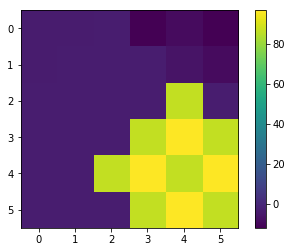

In [21]:
# if the defender is fixed at the bottom left corner, this heatmap shows the invader's rewards
plt.imshow(invader_map, interpolation='nearest')
plt.colorbar()
plt.show()

In [22]:
# create a list of states that fixes the invaders's starting position
fixed_invader_state_list = []
for defender_state in invader_defender.states:
    fixed_invader_state = defender_state + [0, 0]
    fixed_invader_state_list.append(fixed_invader_state)

# create invader heatmap
defender_map = np.zeros([6,6])
for state in fixed_invader_state_list:
    defender_map[state[0], state[1]] = U[k][tuple(state)]

In [23]:
defender_map

array([[25.31233309, 25.31233309, 25.13146452,  5.94633309,  5.35169979,
         3.97803309],
       [25.31233309, 25.22189881, 25.31233309, 18.13146452,  5.94633309,
         5.35169979],
       [25.13146452, 25.31233309, 21.63146452, 18.31233309, 12.73146452,
         5.94633309],
       [ 5.94633309, 18.13146452, 18.31233309, 14.08146452, 12.67331807,
         8.68146452],
       [ 5.35169979,  5.94633309, 12.73146452, 12.67331807,  9.18771452,
         8.26894307],
       [ 3.97803309,  5.35169979,  5.94633309,  8.68146452,  8.26894307,
         6.0454667 ]])

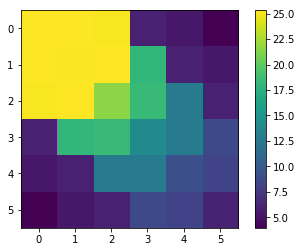

In [24]:
# if invader is fixed at top left corner, this heatmap shows the defender's rewards
plt.imshow(defender_map, interpolation='nearest')
plt.colorbar()
plt.show()

## Plot Delta 

In [25]:
# plt.plot(delta_list)
# plt.title('Iteration vs Delta')
# plt.xlabel('Iteration')
# plt.xticks(np.arange(0, k, k/10))
# plt.ylabel('Delta')

## Defender and Invader Policy 

In [26]:
defender_policy

{(0,
  5,
  5,
  2): array([6.16297582e-33, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]),
 (3,
  3,
  5,
  4): array([0.00000000e+00, 1.11022302e-16, 1.00000000e+00, 0.00000000e+00]),
 (5,
  1,
  0,
  3): array([ 1.00000000e+00, -1.11022302e-16,  0.00000000e+00,  0.00000000e+00]),
 (5,
  3,
  5,
  0): array([0.00000000e+00, 0.00000000e+00, 2.22044605e-16, 1.00000000e+00]),
 (3, 1, 2, 0): array([0.        , 0.04274975, 0.        , 0.95725025]),
 (0,
  4,
  1,
  2): array([0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.11022302e-16]),
 (3, 3, 1, 5): array([0.5002271, 0.4997729, 0.       , 0.       ]),
 (5, 4, 5, 0): array([0., 0., 0., 1.]),
 (4, 4, 4, 1): array([0., 0., 0., 1.]),
 (0, 2, 2, 4): array([0., 1., 0., 0.]),
 (4, 3, 4, 1): array([0.        , 0.        , 0.99010973, 0.00989027]),
 (3,
  1,
  2,
  1): array([0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 3.8430797e-16]),
 (1,
  1,
  0,
  3): array([0.00000000e+00, 1.00000000e+00, 1.11022302e-15, 0.00000000e+00]),
 (4, 2, 5,

In [27]:
invader_policy

{(0, 5, 5, 2): array([0., 0., 0., 1.]),
 (3,
  3,
  5,
  4): array([ 4.88498131e-15,  1.00000000e+00, -4.88498131e-15,  0.00000000e+00]),
 (5, 1, 0, 3): array([0., 1., 0., 0.]),
 (5, 3, 5, 0): array([1., 0., 0., 0.]),
 (3,
  1,
  2,
  0): array([0.00000000e+00, 1.00000000e+00, 2.26485497e-14, 0.00000000e+00]),
 (0, 4, 1, 2): array([0., 0., 1., 0.]),
 (3, 3, 1, 5): array([0.        , 0.        , 0.45430259, 0.54569741]),
 (5, 4, 5, 0): array([0., 0., 1., 0.]),
 (4, 4, 4, 1): array([0., 1., 0., 0.]),
 (0, 2, 2, 4): array([0., 0., 1., 0.]),
 (4, 3, 4, 1): array([0.05536002, 0.94463998, 0.        , 0.        ]),
 (3, 1, 2, 1): array([0., 0., 1., 0.]),
 (1, 1, 0, 3): array([0., 1., 0., 0.]),
 (4, 2, 5, 4): array([0., 1., 0., 0.]),
 (0, 1, 4, 4): array([0., 0., 1., 0.]),
 (0, 4, 5, 1): array([0., 1., 0., 0.]),
 (5,
  1,
  4,
  1): array([0.00000000e+00, 1.00000000e+00, 1.11022302e-16, 0.00000000e+00]),
 (5, 1, 0, 1): array([0., 0., 1., 0.]),
 (0, 1, 0, 5): array([0., 0., 1., 0.]),
 (1, 1, 0,